In [1]:
from madhatter import *
from madhatter.loaders import *

from nltk.corpus import gutenberg
from nltk.corpus import europarl_raw

import pandas as pd
from multiprocess.pool import Pool
# A progress bar to try to give an overall idea of the progress made.
from tqdm import tqdm
import pickle
from pathlib import Path
from os import path

input_length = 100_000


In [2]:
# nlp = spacy.load("en_core_web_sm", disable=[
#                  "ner",
#                  #  "lemmatizer",
#                  "textcat", "attribute_ruler"])
# nlp.pipe_names


def read_texts(path: Path | str, length: int = 1_000_000) -> list[str]:
    """Returns a list of strings sequentially read from the path specified as the option. 

    Parameters
    ----------
    path : Path
        Path to read from. The document will be opened in text-mode.
    length : int, optional
        The desired length of all texts, by default 1_000_000

    Returns
    -------
    list[str]
        List of the read character sequences.
    """
    with open(path) as f:
        text = []
        line = f.read(length)
        while len(line) > 0:
            text.append(line)
            line = f.read(length)
    return text


def split_strings(string: str, length=1_000_000):
    ret = []
    i = 0
    read = string[i*length:(i+1)*length]
    while len(read) > 0:
        ret.append(read)
        i += 1
        read = string[i*length:(i+1)*length]
    return ret


SpaCy performance concerns

| Processes | Total Time (s) | Peak Total Memory (MB) |
| --- | --- | --- |
| 1 (SpaCy pipe) | 25.104 | 6487 |
| 16 (SpaCy pipe) | 45.345 | 6340 |
| 16 (multiprocessing) | 8.313 | 6679 |


### Memory usage of Spacy vs Custom Package
| Framework | peak memory | increment |
|-----------|-------------|-----------|
| Spacy | 5089.13 MiB |  4465.29 MiB |
| Mad Hatter| 434.81 MiB  | 48.75 MiB |

Increment here is the more important number as it tells us how memory usage peaks when performing a given operation.


## Experimentation with pipelines
Here we prepare a pipeline that will take the list of resources and return a list of `Report` objects. Those `Report` objects are then fed into a Pandas dataframe for further analysis. For better performance, we use the `multiprocessing` module to parallelize the pipeline, as each text is largely independent.


Example listing of the pipeline:
```python
def pipeline(resources: list[str]):
    reports = []
    for resource in resources:
        report = Report(resource)
        reports.append(report)
    return reports
```

In [3]:
def process(file: str, title: str | None = None) -> Report:
    return CreativityBenchmark(file, title if title is not None else "unknown").report(print_time=False, postag_distribution=True)


def process_texts(args, processes: int = 16):
    with Pool(processes) as p:
        return p.starmap(process, tqdm(args, total=len(args)))


def save_results(results, savepath):
    with open(savepath, 'wb') as file:
        pickle.dump(results, file)


def load_results(savepath):
    with open(savepath, 'rb') as file:
        return pickle.load(file)


## Measuring the Gutenberg/Fiction dataset
Note the lack of variety here. Gutenberg only has 18 works, but they lead to 2124 texts of length 100000. This may be a somewhat flawed methodology so I recommend exploring more fictional works.

2124


,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,austen-emma.txt,20736,3.944541,110.286674,24.076148,0.602334,2.736829,3.338598,-2.373265,"{'NOUN': 0.17213953488372094, 'VERB': 0.180976...",1
1,austen-emma.txt,21070,3.874798,110.817568,24.546171,0.600237,2.744145,3.407837,-2.375355,"{'NOUN': 0.16750011469468276, 'VERB': 0.177042...",1
2,austen-emma.txt,20499,3.996878,146.833581,31.341753,0.578370,2.679235,3.276575,-2.343437,"{'VERB': 0.18124496278386196, 'NOUN': 0.170293...",1
3,austen-emma.txt,20905,3.920497,124.547980,27.282828,0.606553,2.733417,3.331522,-2.376738,"{'NOUN': 0.16591077378748612, 'VERB': 0.189374...",1
4,austen-emma.txt,21117,3.873325,97.063241,21.721344,0.630487,2.727581,3.265606,-2.399655,"{'NOUN': 0.16577199526885633, 'VERB': 0.188199...",1


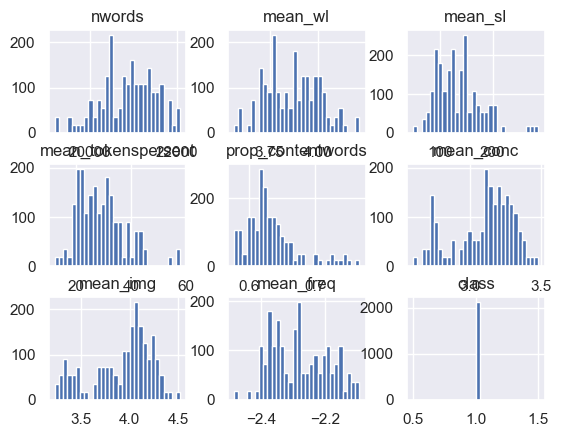

In [147]:
creative_fns = [file for file in gutenberg.fileids()]
creative_files = []
for file in creative_fns:
    listt = split_strings(gutenberg.raw(creative_fns), length=input_length)
    creative_files.extend([(_, file) for _ in listt])

print(len(creative_files))

savepath_creative = Path("./results/.creative")

if savepath_creative.exists():
    creative_results = load_results(savepath_creative)
else:
    creative_results = process_texts(creative_files)
    save_results(creative_results, savepath_creative)

creative_df = pd.DataFrame(creative_results)
creative_df.insert(creative_df.shape[1], "class", 1)

creative_df.hist(bins=30)
creative_df.head()


## Loading legal datasets into the pipeline

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,legal_text_0,18053,4.672464,652.601307,118.921569,0.686146,3.016673,4.358274,-2.086670,"{'NOUN': 0.37032151690024734, 'VERB': 0.078428...",2
1,legal_text_1,17597,4.775530,394.260870,70.438735,0.655396,2.973358,4.090671,-2.138984,"{'VERB': 0.08041075136075417, 'NOUN': 0.355367...",2
2,legal_text_2,17652,4.777872,422.733051,75.788136,0.686891,3.024933,4.169661,-2.123103,"{'ADJ': 0.044727720004472775, 'NOUN': 0.378172...",2
3,legal_text_3,18013,4.673569,486.809756,88.814634,0.683451,2.900618,4.209920,-2.122910,"{'VERB': 0.08776844070961717, 'NOUN': 0.373977...",2
4,legal_text_4,17695,4.737157,410.522634,73.522634,0.627804,2.966905,4.149116,-2.109856,"{'NOUN': 0.34081495578193216, 'VERB': 0.090619...",2


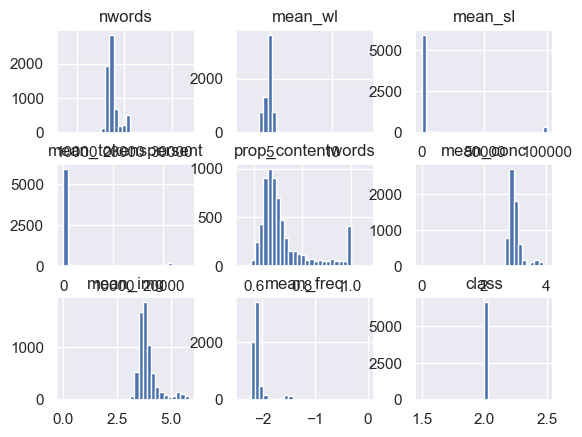

In [146]:
legal_path = Path("./results/.legal")
if legal_path.exists():
    legal_results = load_results(legal_path)
else:
        
    legal_texts = read_texts(ds_dgt(), length=input_length)

    europarl_txt = split_strings("".join([" ".join(
        [" ".join(para) for para in chap]) for chap in europarl_raw.english.chapters()]), length=input_length)
    legal_texts.extend(europarl_txt)

    legal_results = process_texts(
        [(legal_text, f"legal_text_{i}") for i, legal_text in enumerate(legal_texts)])
    
    save_results(legal_results, legal_path)

legal_df = pd.DataFrame(legal_results)
legal_df.insert(legal_df.shape[1], "class", 2)

legal_df.hist(bins=30)
legal_df.head()


## Loading writing prompts

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,writingprompts_0,22315,3.571230,72.260806,16.353114,0.698812,3.228014,3.993187,-2.310648,"{'ADJ': 0.07839799301137891, 'NOUN': 0.2622076...",3
1,writingprompts_1,22543,3.525352,66.204973,15.162634,0.693475,3.219386,3.998758,-2.318405,"{'NOUN': 0.26163460686109385, 'VERB': 0.165100...",3
2,writingprompts_2,21895,3.647910,78.745614,17.480861,0.681297,3.262477,4.073366,-2.311806,"{'VERB': 0.1637242826513389, 'ADJ': 0.07668445...",3
3,writingprompts_3,22261,3.595571,68.348821,15.459085,0.706662,3.160694,4.004470,-2.270799,"{'ADJ': 0.08038758298941324, 'NOUN': 0.2839583...",3
4,writingprompts_4,22822,3.474805,70.736011,16.406026,0.695031,3.277664,4.056539,-2.341960,"{'NOUN': 0.26628771316134675, 'ADJ': 0.0786182...",3


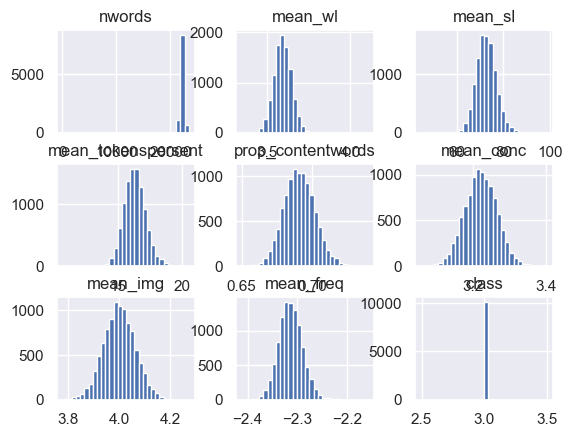

In [148]:
wp_savepath = Path("./results/.wp")
if wp_savepath.exists():
    wp_results = load_results(wp_savepath)
else:
    # TODO: Possibly try out stuff like actually splitting the writingprompts dataset instead of reading continuous text.

    wp_path = ds_writingprompts()
    writingprompts = read_texts(wp_path["train"][1], length=input_length)
    writingprompts.extend(read_texts(wp_path["test"][1], length=input_length))
    writingprompts.extend(read_texts(wp_path["val"][1], length=input_length))

    wp_results = process_texts(
        list((_, f"writingprompts_{i}") for i, _ in enumerate(writingprompts)))

    # Length (100_000 chars) = 100089
    print(f"Length of writingprompts dataset: {len(writingprompts)}")
    # Whole thing took around 35 minutes on battery charge
    save_results(wp_results, wp_savepath)


writingprompts_df = pd.DataFrame(wp_results)
writingprompts_df.insert(writingprompts_df.shape[1], "class", 3)

writingprompts_df.hist(bins=30)
writingprompts_df.head()


A little visualization of what is happening behind the scenes. It seems like the novels have quite a bit more variety behind them at first glance. 

## Experiment


After running the pipeline, we concatenate the results into a single dataframe which we can then use for further analysis. 

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Join
df = pd.concat([creative_df, writingprompts_df, legal_df], ignore_index=True)
df = df.join(pd.json_normalize(df["prop_pos"]).fillna(0.0))  # type: ignore

# drop unneeded columns and select features
xdf = df.drop(["title", "class", "prop_pos"], axis=1)

# drop arbitrary columns to see how results change
xdf = xdf.drop("nwords", axis=1)
ydf = df["class"]

# make the splits
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, test_size=0.1)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1)

# create the pipeline
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(xtrain, ytrain)  # apply scaling on training data

# test the scoring
print(f"Val split score: {pipe.score(xval, yval):.5f}")
print(f"Test split score: {pipe.score(xtest, ytest):.5f}")

Val split score: 0.99823
Test split score: 0.99894


,0,1,2
mean_wl,0.183398,3.879265,-4.062664
mean_sl,-0.299411,0.363406,-0.063994
mean_tokenspersent,-0.479574,0.540431,-0.060858
prop_contentwords,0.474877,-0.717387,0.242510
mean_conc,-0.844526,0.328622,0.515904
mean_img,1.210159,-2.040119,0.829960
mean_freq,-0.499564,2.691693,-2.192130
NOUN,-4.321936,1.236530,3.085406
VERB,-1.622277,-2.187022,3.809299
ADJ,-1.752664,-1.014645,2.767309


<BarContainer object of 10 artists>

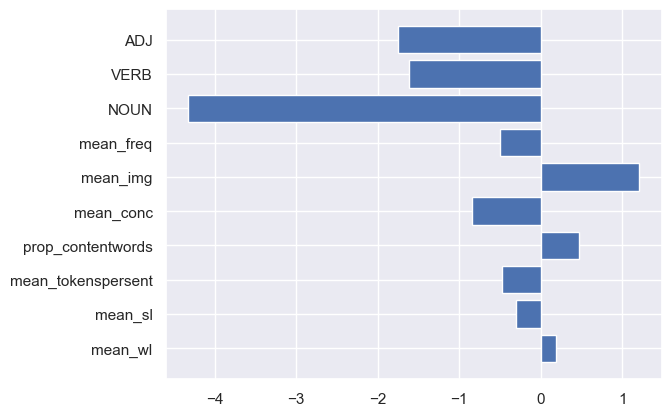

In [115]:
import matplotlib.pyplot as plt
display_df = pd.DataFrame(pipe['logisticregression'].coef_.T, index=xdf.columns) # type: ignore
display(display_df)

plt.barh(display_df.index, display_df[0])

- Write about lemmatization approaches
- Possibly make a diagram for how the process goes

In [149]:
import string

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'